# Kings County Housing Prices Bakeoff

Below are a list of steps that you should take while trying to complete your bake-off entry.

# Step 1: Read in Data

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', '{:.2f}'.format)
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt

import scipy
import statistics as stats
import numpy as np

from sklearn import linear_model
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression


df = pd.read_csv('Resources/kc_house_data_train.csv', index_col=0)
df = df.drop(['id'], axis=1)

In [2]:
import statistics as stats

In [3]:
#adjusting bedrooms outliers 
df['bedrooms'] = df['bedrooms'].apply(lambda x : 9 if x > 9 else x)
#np.where(df['my_channel'] > 20000, 0, df['my_channel'])

In [4]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141006T000000,365000.00,4,2.25,2070,8893,2.00,0,0,4,8,2070,0,1986,0,98058,47.44,-122.16,2390,7700
1,20140821T000000,865000.00,5,3.00,2900,6730,1.00,0,0,5,8,1830,1070,1977,0,98115,47.68,-122.28,2370,6283
2,20140815T000000,1038000.00,4,2.50,3770,10893,2.00,0,2,3,11,3770,0,1997,0,98006,47.56,-122.13,3710,9685
3,20150331T000000,1490000.00,3,3.50,4560,14608,2.00,0,2,3,12,4560,0,1990,0,98034,47.70,-122.23,4050,14226
4,20140714T000000,711000.00,3,2.50,2550,5376,2.00,0,0,3,9,2550,0,2004,0,98052,47.66,-122.08,2250,4050


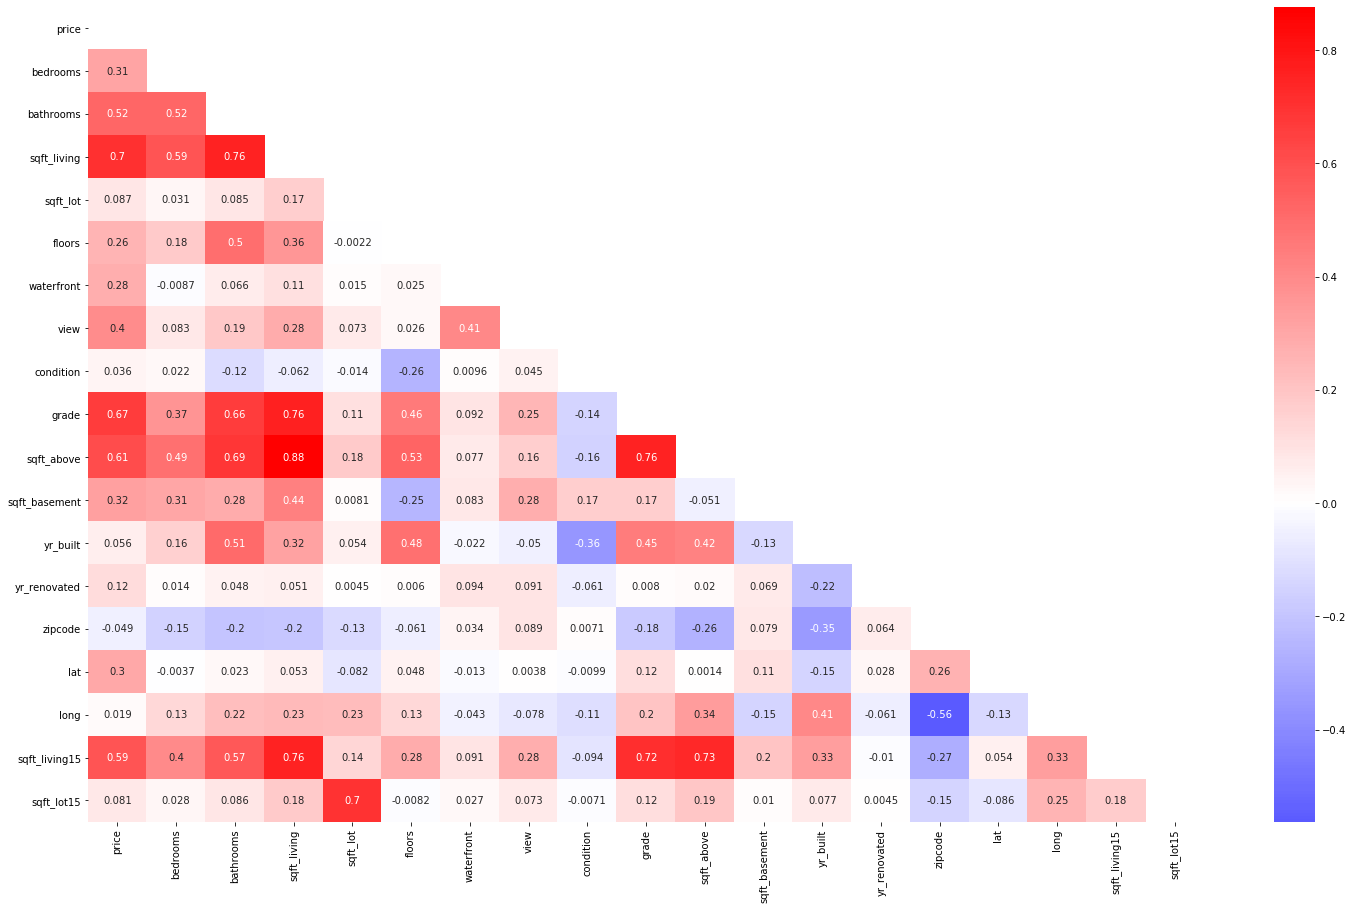

In [5]:
#create a heatmap to visualize the correlations
fig, ax = plt.subplots(figsize=(25,15)) # figsize to make larger
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, cmap='bwr', center=0, annot=True)

# fix for matplotlib bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.show()

# Step 2: EDA
### Initial Findings and planning
- **highest correlations:** 'bathrooms', 'sqft_living', 'grade', 'sqft_above', 'sqft_living15' (check for outliers and extreme values)
    - sqft_living seems like a better predictor
- **suprisingly low correlations:** 'bedrooms', 'waterfront', 'view', 'condition', 'renovated_0' 
    - see if manipulation helps with correlation
- check out for outliers in price by sqft
- 33 bedrooms outlier
- bin `condition` into 3 categories: 1/2, 3/4, and 5
- bin `view` into 3 categories: 0, 1&2, 3, 4 (create poly?)
- `grade` poly?
- dummy code zip codes
- check out distances from Seattle city center with `lat` and `long`
- viz for floors
- waterfront: t-test

In [6]:
#changing date format workable month

df['month_sold'] = pd.to_datetime(df['date'].str.slice(0,8), format='%Y%m%d', errors='ignore').dt.month
df.drop('date',axis=1,inplace=True)

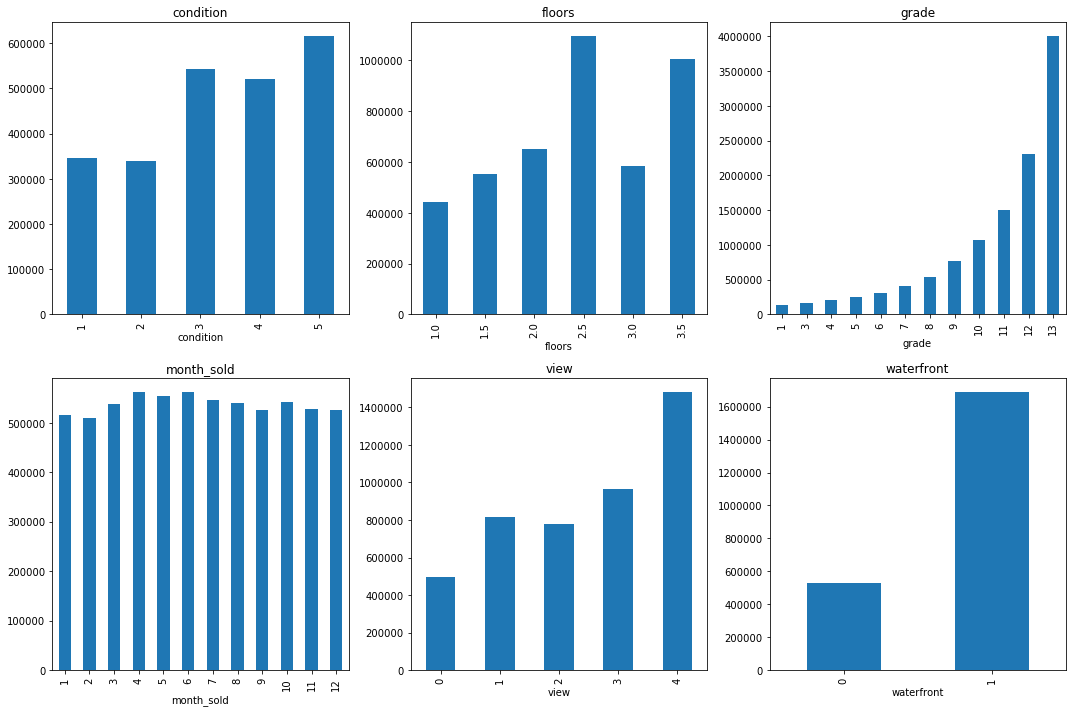

In [7]:
# Bar plots of categorical data
#zipcode explored later
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))

categoricals = ['condition', 'floors', 'grade', 'month_sold', 'view', 'waterfront']

for col, ax in zip(categoricals, axes.flatten()):
    (df.groupby(col)               # group values together by column of interest
         .mean()['price']        # take the mean of the saleprice for each group
         .plot
         .bar(ax=ax))                # create a bar graph on the ax    
    ax.set_title(col)                # Make the title the name of the column
fig.tight_layout()

# Investigation

### Outcome Variable: Price
may keep `price` as-is -- perhaps bring outliers down to 6000000? Let's see how models do with both options

NOTE: may help to normalize/scale/log

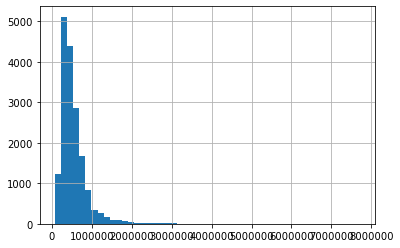

In [8]:
df.price.hist(bins=50)
plt.show()

### 1. Bathrooms

Text(0.5, 0, 'Bathrooms')

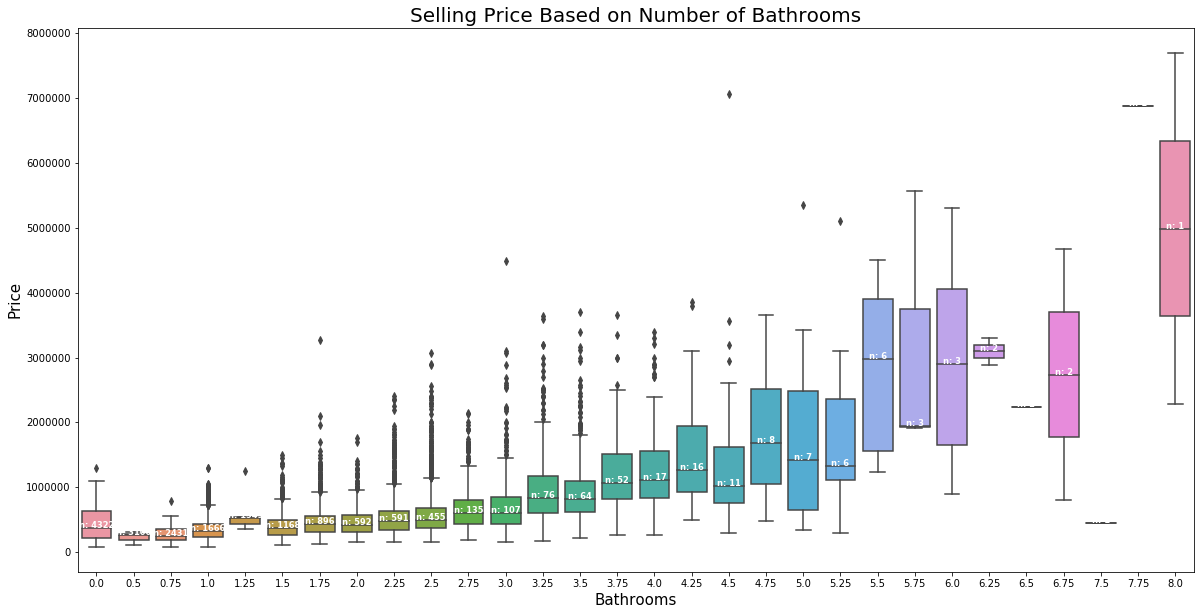

In [9]:
plt.figure(figsize=(20,10))
ax = sns.boxplot(x=df['bathrooms'], y=df['price'], data=df)
 
# Calculate number of obs per group & median to position labels
medians = df.groupby(['bathrooms'])['price'].median().values
nobs = df['bathrooms'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 0.03, nobs[tick],
horizontalalignment='center', size='small', color='w', weight='semibold')
    
plt.title('Selling Price Based on Number of Bathrooms', size=20)
plt.ylabel('Price', size=15)
plt.xlabel('Bathrooms', size=15)

### 2. Grade - Construction Rating

Text(0.5, 0, 'Building and Construction Rating')

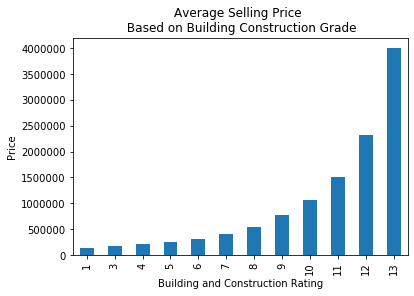

In [10]:
#Barplot Price v Grade
df.groupby('grade')['price'].mean().plot(kind='bar')

#Set labels
plt.title('Average Selling Price \n Based on Building Construction Grade', size=12)
plt.ylabel('Price')
plt.xlabel('Building and Construction Rating')

## Suprisingly weak correlations
- 'bedrooms', 'waterfront', 'view', 'condition', ('renovated_0' for later)

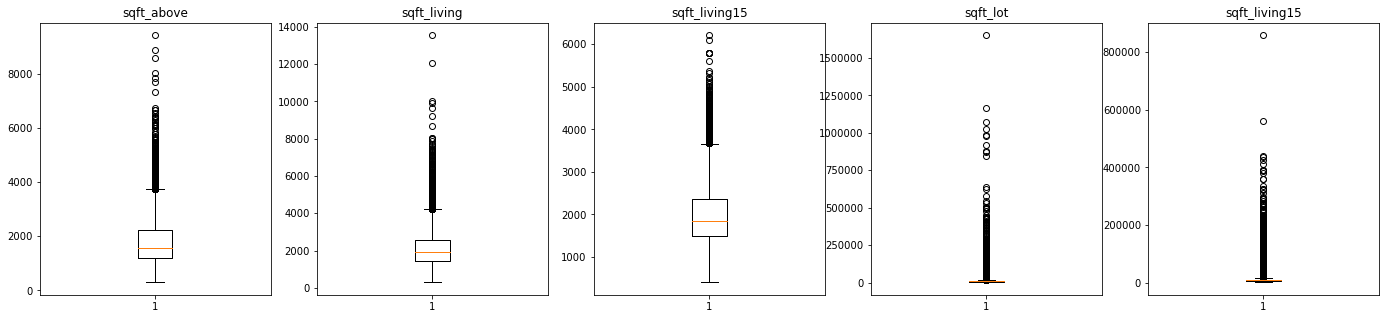

In [11]:
# Investigating Outliers - sqft_

plt.figure(figsize=(24,5))

ax3 = plt.subplot(1, 5, 1)
plt.boxplot(df.sqft_above)
ax3.set_title('sqft_above')

ax1 = plt.subplot(1, 5, 2)
plt.boxplot(df.sqft_living)
ax1.set_title('sqft_living')

ax2 = plt.subplot(1, 5, 3)
plt.boxplot(df.sqft_living15)
ax2.set_title('sqft_living15')


ax3 = plt.subplot(1, 5, 4)
plt.boxplot(df.sqft_lot)
ax3.set_title('sqft_lot')

ax3 = plt.subplot(1, 5, 5)
plt.boxplot(df.sqft_lot15)
ax3.set_title('sqft_living15')

plt.show()

In [12]:
# adjuting sqft home outliers to within 6 standard deviations of the mean
for col in ['sqft_above', 'sqft_living', 'sqft_living15']: 
    above_6std = df[col].mean()+(6*df[col].std())
    df[col] = np.where(df[col].values >above_6std, df[col].mean()+6*df[col].std(), df[col])
    
# adjusting lot outliers to within 9 standard deviations of the mean
for col in ['sqft_lot', 'sqft_lot15']: 
    above_9std = df[col].mean()+(9*df[col].std())
    df[col] = np.where(df[col].values >above_6std, df[col].mean()+9*df[col].std(), df[col])

# Try these to see if they improve model

In [13]:
#Fixing 'bathrooms' outliers
bathroom_median = df.bathrooms.median()
df.loc[df.bathrooms == 0, 'bathrooms'] = np.nan
df.fillna(bathroom_median,inplace=True)

#df['bathrooms'] = np.where(df.bathrooms>6, 6, df['bathrooms']) 

In [14]:
df['floors_x_sqft_living'] = df['floors']*df['sqft_living']

In [15]:
#Create dummy columns of 'condition' 
df = pd.get_dummies(df, columns=['condition'], drop_first=True)

In [16]:
#Create dummy columns of 'view'
df = pd.get_dummies(df, columns=['view'], drop_first=True)

In [17]:
#Create dummy columns of 'floors'
df = pd.get_dummies(df, columns=['floors'], drop_first=True)

# Step 4: Generate new features that you think could be important.

After doing this, you will want to go back to steps 2 and 3 to investigate these new features.

In [18]:
#adjusting bedrooms outliers 
df['bedrooms'] = df['bedrooms'].apply(lambda x : 9 if x > 9 else x)


In [19]:
## RUN THIS CELL ONLY ONCE!

#Create new column 'age' for age of house
df['age'] = 2015 - df.yr_built

#Create dummy variable 'basement' y/n
df['basement'] = np.where(df['sqft_basement']>0 , 1, 0)
df = pd.get_dummies(df, columns=['basement'])
df = df.drop(['basement_0'], axis=1)

#Create a new column 'neighbors_compared' with sqft_living - sqft_living15
df['neighbors_compared'] = df.sqft_living - df.sqft_living15

#Create dummy columns using 'nc_2'
df['nc2'] = np.where(df['sqft_living']> df['sqft_living15'] , 1, 0)
df = pd.get_dummies(df, columns=['nc2'])
df = df.drop(['nc2_0'], axis=1)


#### Playing with `renovated` columns:

In [20]:
#RUN CELL ONLY ONCE

#Create new column 'last_renovted' for how long ago since last renovation
df['last_ren'] = np.where(df['yr_renovated'] > 0, (2015 - df['yr_renovated']), 0)

#Create new column 'last_ren2' for how long (years) since last renovation and including age if no renovation
df['last_ren2'] = np.where(df['yr_renovated'] > 0, (2015 - df['yr_renovated']), (2015 - df['yr_built']))

#Create dummy columns using 'renovated'
df['renovated'] = np.where(df['yr_renovated']>0 , 1, 0)
df = pd.get_dummies(df, columns=['renovated'], drop_first=True)


#### Create dummy zip codes

In [21]:
# Create dummy variables for zipcodes
zip_dummies = pd.get_dummies(df['zipcode'].astype(str), drop_first=True)
df.drop('zipcode',axis=1,inplace=True)

## Checking on new features

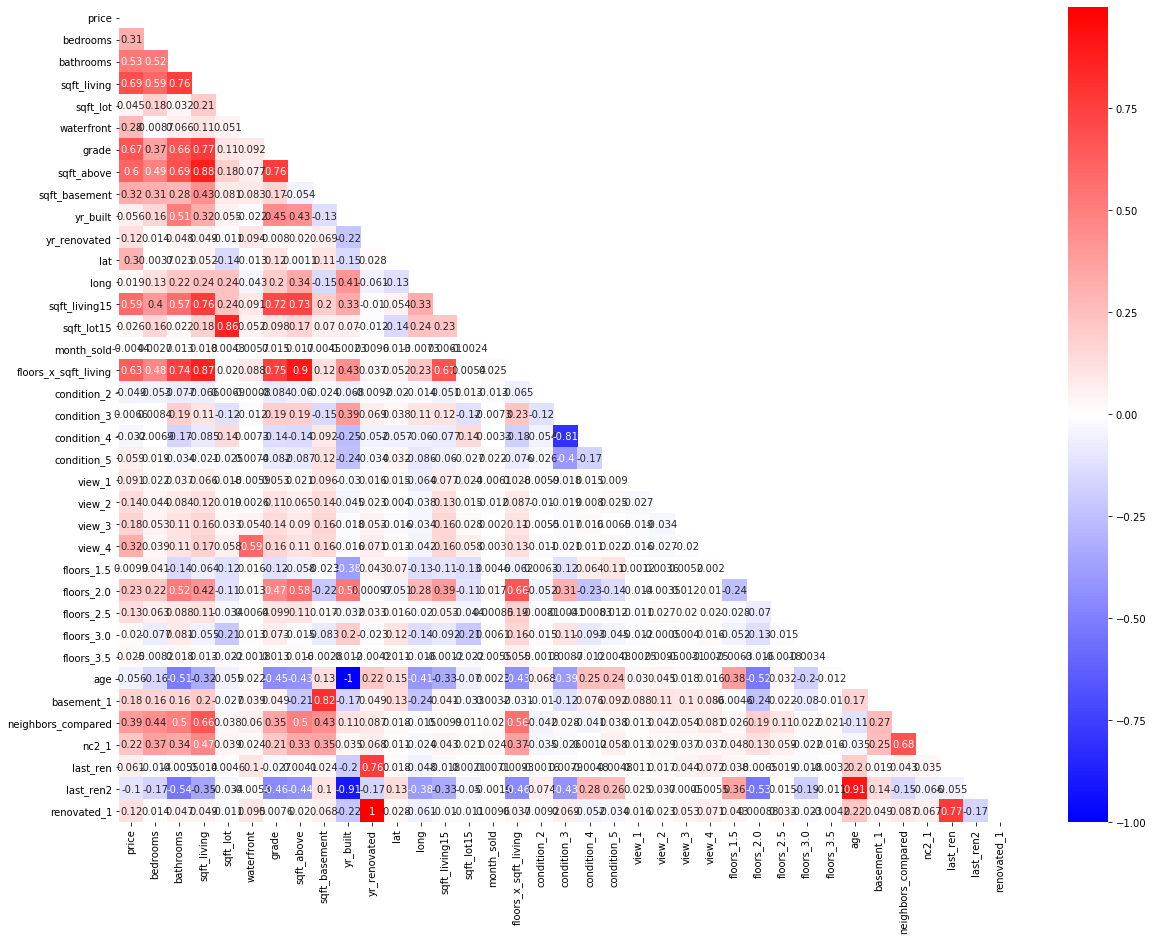

In [22]:
# Correlation matrix
fig, ax = plt.subplots(figsize=(20, 15))

corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, cmap='bwr', center=0, annot=True)

# fix for matplotlib bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.show()

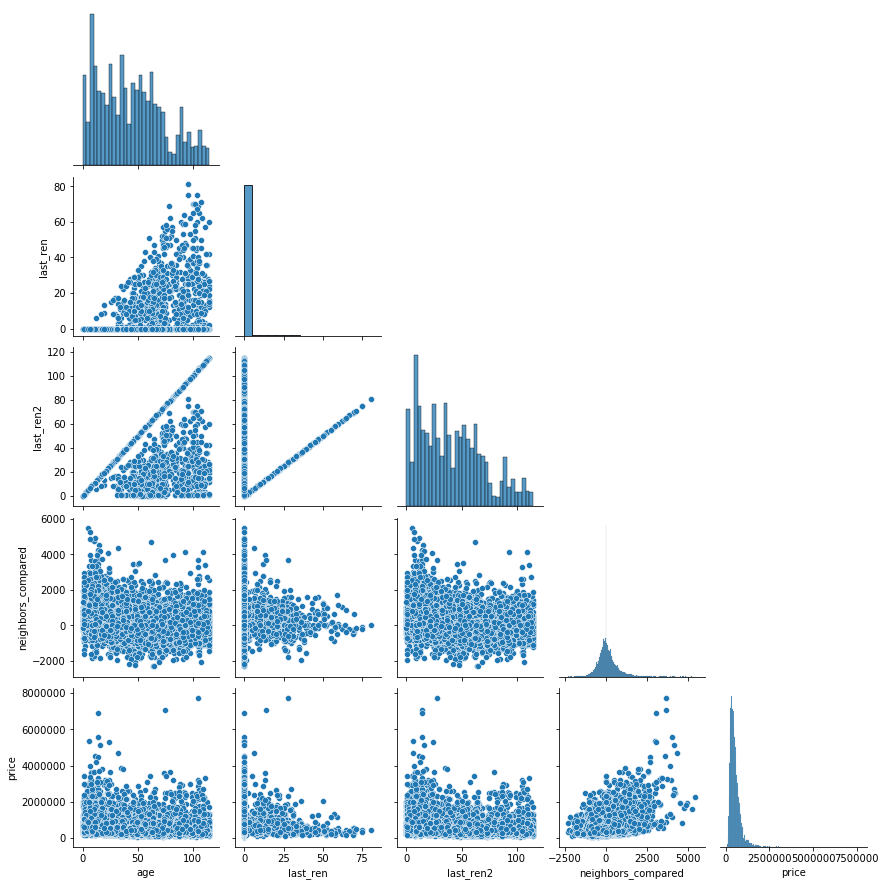

In [23]:
#Checking on new continuous features
sns.pairplot(df[['age', 'last_ren', 'last_ren2', 'neighbors_compared', 'price']], corner=True)


###### 3 Statistical tests - waterfront, basement_1, renovated_1, nc2_1
- below calculations show that p-values are all below .05 alpha, so we can use these in our final model

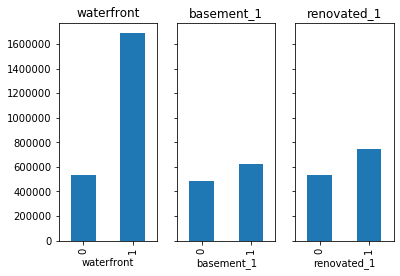

In [24]:
# Checking on new qualitative features

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True)

categoricals = ['waterfront','basement_1', 'renovated_1',]

for col, ax in zip(categoricals, axes.flatten()):
    (df.groupby(col).mean()['price']
         .sort_values()              # sort the groups in ascending order if desired
         .plot.bar(ax=ax))
    ax.set_title(col)
#fig.tight_layout()

##### waterfront

In [25]:
waterfront1 = df[df['waterfront']==1]
waterfront0 = df[df['waterfront']==0]

In [26]:
print(stats.variance(waterfront0.price)/stats.variance(waterfront1.price))

0.09165343432106077


In [27]:
# perform welch's t-test (two-tailed by default)
wf_ttest = scipy.stats.ttest_ind(waterfront1.price, waterfront0.price, equal_var=False)
wf_ttest

Ttest_indResult(statistic=11.903695918563983, pvalue=6.940441256090536e-23)

##### basement

In [28]:
basement1 = df[df['basement_1']==1]
basement0 = df[df['basement_1']==0]

In [29]:
print(stats.variance(basement0.price)/stats.variance(basement1.price))

0.4323918400142645


In [30]:
# perform welch's t-test (two-tailed by default)
bsmnt_ttest = scipy.stats.ttest_ind(basement1.price, basement0.price, equal_var=False)
bsmnt_ttest

Ttest_indResult(statistic=21.726203698496963, pvalue=1.935598808013724e-102)

##### renovated

In [31]:
renovated1 = df[df['renovated_1']==1]
renovated0 = df[df['renovated_1']==0]

In [32]:
print(stats.variance(renovated0.price)/stats.variance(renovated1.price))
# print(stats.variance(renovated0.price))
# print(stats.variance(renovated1.price))        

0.3271904780939962


In [33]:
# perform welch's t-test (two-tailed by default)
ren_ttest = scipy.stats.ttest_ind(renovated1.price, renovated0.price, equal_var=False)
ren_ttest

Ttest_indResult(statistic=9.400954343413524, pvalue=6.478917377975333e-20)

In [34]:
#Drop unwanted columns to avoid multicollinearity
to_drop = ['last_ren',
          'month_sold',
          'nc2_1',
          'yr_built',
          'yr_renovated']
df = df.drop(to_drop, axis=1)

### <ins>Non-linear transformations</ins>

### 4.4) Create a polynomial feature for two of your continuous variables.

# Step 5: Train-Test Split

### 5.1) Perform a train-test split of the data.

This code will need to be re-run with list(df.columns) if features are added

In [35]:
# Concat DFs together
df_features = pd.concat([df, zip_dummies], axis=1)

In [36]:
df_features = df_features.iloc[:,1:]
target = df['price']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(df_features, target, random_state=42,test_size=0.2)

#check the shape of the results
print("Training set - Features: ", X_train.shape, "Target: ", y_train.shape)
print("Training set - Features: ", X_test.shape, "Target: ",y_test.shape)

Training set - Features:  (13832, 100) Target:  (13832,)
Training set - Features:  (3458, 100) Target:  (3458,)


In [38]:
#instantiate and fit
lm = LinearRegression()
lm = lm.fit(X_train, y_train)

y_pred = lm.predict(X_test)

#Evaluate
test_mae = metrics.mean_absolute_error(y_test, y_pred) # <-----
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred)) # <-----

print('Simple Model RMSE:' + str(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
print('Simple Model RMSE:' + str(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))

Simple Model RMSE:151041.14533971073


# Log
- LOG Training Root Mean Squared Error: 132525.4083570364
- LOG Testing Root Mean Squared Error:  135068

In [39]:
y_log = np.log(y_train)

# instantiate a linear regression object and fit
lm_log = LinearRegression()
lm_log = lm_log.fit(X_train, y_log)

In [40]:
log_train_pred = lm_log.predict(X_train)

# exponentiate the predictions to get them on the same original scale 
y_train_pred = np.exp(log_train_pred)
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

print('LOG Training Root Mean Squared Error:' , train_rmse)

LOG Training Root Mean Squared Error: 132525.4083570364


In [41]:
log_test_pred = lm_log.predict(X_test)

# exponentiate the predictions to get them on the same original scale 
log_test_pred = np.exp(log_test_pred)
log_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, log_test_pred))

print('LOG Training Root Mean Squared Error:' , train_rmse)
print('LOG Testing Root Mean Squared Error: ' , log_test_rmse)

LOG Training Root Mean Squared Error: 132525.4083570364
LOG Testing Root Mean Squared Error:  135068.4094375776


In [42]:
# Checking mae vs rmse
metrics.mean_absolute_error(y_train, y_train_pred) 

75550.58276804071

In [43]:
#If we decide to use Log, run this cell!!

# reassign y_test_pred to our log model
y_test_pred = lm_log.predict(X_test)

#our model predicted the log of gross, so now we must exponentiate to get value back in $
y_test_pred = np.exp(y_test_pred)

test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

#print('Testing Root Mean Squared Error:' , test_rmse)
print('Training: ', int(train_rmse), "vs. Testing: ", int(test_rmse))

Training:  132525 vs. Testing:  135068


# Polynomial Features

## Poly 2

#### Poly with Kbest (28)
- KBEST Training Root Mean Squared Error: 203755
- KBEST Testing Root Mean Squared Error: 195926

##### Poly2 before feature selection

In [44]:
poly_features = df_features
target = df['price']

In [45]:
poly_2 = PolynomialFeatures(degree=2, include_bias=False)
poly2_data = poly_2.fit_transform(poly_features)
poly2_columns = poly_2.get_feature_names(poly_features.columns)
df_poly2 = pd.DataFrame(poly2_data, columns=poly2_columns)
#df_poly2.head() #Sanity Check

In [46]:
X_train, X_test, y_train, y_test = train_test_split(df_poly2, target, random_state=42,test_size=0.2)

In [47]:
# instantiate a linear regression object and fit to training data
lm_2 = LinearRegression()
lm_2 = lm_2.fit(X_train, y_train)

y_train_pred = lm_2.predict(X_train)

train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
print('Training Root Mean Squared Error:' , train_rmse)

Training Root Mean Squared Error: 96116.90709805726


In [48]:
# use fitted model to predict on test data
y_pred = lm_2.predict(X_test)

test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print('Testing Root Mean Squared Error:' , test_rmse)
print('Training: ', int(train_rmse), "vs. Testing: ", int(test_rmse))

Testing Root Mean Squared Error: 2865917.670553348
Training:  96116 vs. Testing:  2865917


In [49]:
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression

selector = SelectKBest(f_regression, k=28) # <----- number of features you want
selector.fit(X_train, y_train)

selected_columns = X_train.columns[selector.get_support()] #kept columns
removed_columns = X_train.columns[~selector.get_support()] #removed columns
#list(selected_columns)
#list(removed_columns)

In [50]:
len(selected_columns)

28

In [51]:
#instantiate a linear regression object and fit to train data
lm_kbest = LinearRegression()
lm_kbest.fit(X_train[selected_columns], y_train)

# Training Root Mean Squared Error
y_train_kbest = lm_kbest.predict(X_train[selected_columns])
trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_kbest))
print('KBEST Training Root Mean Squared Error:' , trainK_rmse)

# Testing Root Mean Squared Error
y_kbest = lm_kbest.predict(X_test[selected_columns])
testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_kbest))
print('KBEST Testing Root Mean Squared Error:' , testK_rmse)

KBEST Training Root Mean Squared Error: 203755.66470181258
KBEST Testing Root Mean Squared Error: 195926.2415329765


##### Poly2 RFE
- Training RMSE: 201,630
- Testing RMSE: 197,283

after zips
- Training RMSE: 179,763
- Testing RMSE: 170,627

In [52]:
# from sklearn.feature_selection import RFECV

# ols = linear_model.LinearRegression()

# selector = RFECV(estimator=ols, step=1, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

# # Fit recursive feature eliminator 
# selector.fit(X_train, y_train)

In [53]:
# selected_rfe = X_train.columns[selector.support_]
# removed_rfe = X_train.columns[~selector.support_]
# # list(selected_rfe)
# # list(removed_rfe)

In [54]:
# #instantiate a linear regression object and fit to train
# lm_rfe = LinearRegression()
# lm_rfe = lm_rfe.fit(X_train[selected_rfe], y_train)

# # Train
# y_rfe = lm_rfe.predict(X_train[selected_rfe])
# trainRFE_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_rfe))
# print('Training Root Mean Squared Error:' , trainRFE_rmse)

# # Test
# y_pred_rfe = lm_rfe.predict(X_test[selected_rfe])
# testRFE_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfe))
# print('Testing Root Mean Squared Error:' , testRFE_rmse)

## Poly 3
performs worse than Poly2
#### Poly3 Log and KBest (86 features) 
- KBEST Training RMSE 193787
- KBEST Testing RMSE: 187970

In [55]:
# poly_3 = PolynomialFeatures(degree=3, include_bias=False)
# poly3_data = poly_3.fit_transform(df_features)
# poly3_columns = poly_3.get_feature_names(df_features.columns)
# df_poly3 = pd.DataFrame(poly3_data, columns=poly3_columns)
# df_poly3.head()

##### Poly3 KBest

In [56]:
# from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression

# selector = SelectKBest(f_regression, k=31) # <----- f_regression and number of features you want
# selector.fit(X_train, y_train)

# selected_columns = X_train.columns[selector.get_support()] #kept columns
# removed_columns = X_train.columns[~selector.get_support()] #removed columns
# list(selected_columns)
# # list(removed_columns)

In [57]:
# #instantiate a linear regression object and fit to train data
# lm_kbest = LinearRegression()
# lm_kbest.fit(X_train[selected_columns], y_train)

# # Training Root Mean Squared Error
# y_train_kbest = lm_kbest.predict(X_train[selected_columns])
# trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_kbest))
# print('KBEST Training Root Mean Squared Error:' , trainK_rmse)

# # Testing Root Mean Squared Error
# y_kbest = lm_kbest.predict(X_test[selected_columns])
# testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_kbest))
# print('KBEST Testing Root Mean Squared Error:' , testK_rmse)

# Refit your best model to the entire dataset.

In [58]:
#instantiate a linear regression object
lm_final = LinearRegression()

#fit the linear regression to the data
lm_final = lm_final.fit(df_poly2[selected_columns], target)

In [59]:
list(selected_columns)

['sqft_living',
 'grade',
 'bedrooms sqft_living',
 'bathrooms sqft_living',
 'bathrooms grade',
 'bathrooms sqft_above',
 'bathrooms sqft_living15',
 'bathrooms floors_x_sqft_living',
 'sqft_living^2',
 'sqft_living grade',
 'sqft_living sqft_above',
 'sqft_living lat',
 'sqft_living long',
 'sqft_living sqft_living15',
 'sqft_living floors_x_sqft_living',
 'grade^2',
 'grade sqft_above',
 'grade lat',
 'grade long',
 'grade sqft_living15',
 'grade floors_x_sqft_living',
 'sqft_above^2',
 'sqft_above sqft_living15',
 'sqft_above floors_x_sqft_living',
 'lat floors_x_sqft_living',
 'long floors_x_sqft_living',
 'sqft_living15 floors_x_sqft_living',
 'floors_x_sqft_living^2']

## Checking model attributes to copy to holdout notebook

In [60]:
list(df_poly2[selected_columns].columns)

['sqft_living',
 'grade',
 'bedrooms sqft_living',
 'bathrooms sqft_living',
 'bathrooms grade',
 'bathrooms sqft_above',
 'bathrooms sqft_living15',
 'bathrooms floors_x_sqft_living',
 'sqft_living^2',
 'sqft_living grade',
 'sqft_living sqft_above',
 'sqft_living lat',
 'sqft_living long',
 'sqft_living sqft_living15',
 'sqft_living floors_x_sqft_living',
 'grade^2',
 'grade sqft_above',
 'grade lat',
 'grade long',
 'grade sqft_living15',
 'grade floors_x_sqft_living',
 'sqft_above^2',
 'sqft_above sqft_living15',
 'sqft_above floors_x_sqft_living',
 'lat floors_x_sqft_living',
 'long floors_x_sqft_living',
 'sqft_living15 floors_x_sqft_living',
 'floors_x_sqft_living^2']

In [61]:
len(lm_final.coef_)

28

# Step 9: Save your final model using pickle.

https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/

In [62]:
import pickle

#Model
pickle_out = open("poly2_modelx.pickle","wb")
pickle.dump(lm_final, pickle_out)
pickle_out.close()